In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shap

from shapflow.flow import (
    CausalLinks, 
    create_xgboost_f,
    build_feature_graph,
    GraphExplainer,
    edge_credits2edge_credit
)

import xgboost as xgb
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import plot

## Generate Data

In [2]:
seed = 0
n = 365*24 # number of samples -> 1 year with 1 sample per hour
np.random.seed(seed)
time = pd.date_range(start='2023-01-01', periods=n, freq='h')
minutes = time.hour*60 + time.minute
norm_minutes = 2*np.pi*(minutes/(24*60)) - np.pi/2

temp = 22 + (np.sin(norm_minutes))/2 * 15 + np.random.normal(0, 0.6, n)

base_load = np.sin((norm_minutes - np.pi*0.8)*2) + 2
load = np.maximum(0.0, temp - 25.0)*0.6 + base_load + np.random.normal(0, 0.5, n)
load = np.maximum(0, load)

generation = (np.sin(norm_minutes) + 1)*1.6 + 1 + np.random.normal(0, 0.4, n)
generation = np.maximum(0, generation)
# synthetic model features: temp, load, generation, price
# temp -> load; temp, load, generation -> price and ideally not temp -> price (directly)

price = 30 + load - generation

data = pd.DataFrame.from_dict({'Temperature': temp,
                               'Load': load,
                               'Generation': generation})
data.index=time

prediction_target = pd.DataFrame.from_dict({'Price': price})
prediction_target.index=time

# split data into train and test set
block_size = '4d'
masker = [pd.Series(g.index) for n, g in data.groupby(pd.Grouper(freq=block_size))]
train_mask, test_mask = train_test_split(masker, test_size = 0.2, random_state=7)

X_train = data.loc[pd.concat(train_mask)]
y_train = prediction_target.loc[pd.concat(train_mask)]
X_test = data.loc[pd.concat(test_mask)]
y_test = prediction_target.loc[pd.concat(test_mask)]
#X_train, X_test, y_train, y_test = train_test_split(data, prediction_target, test_size=0.2, random_state=7)
xgb_train = xgb.DMatrix(data=X_train, label=y_train)
xgb_test = xgb.DMatrix(data=X_test, label=y_test)

In [3]:
data.mean()

Temperature    21.990419
Load            2.655255
Generation      2.601240
dtype: float64

## plot data

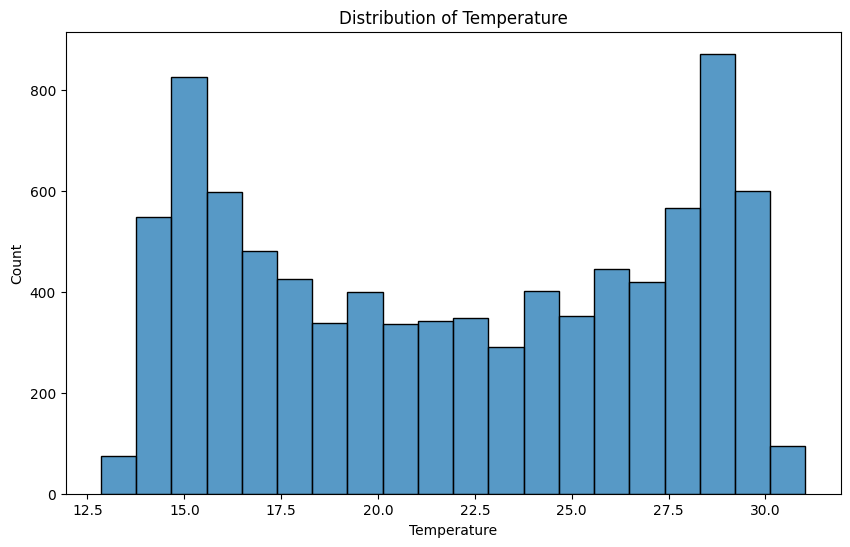

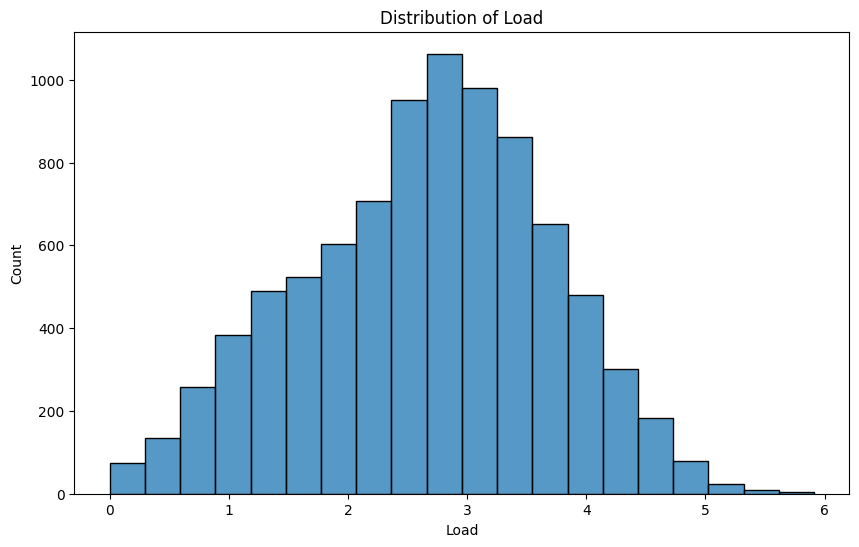

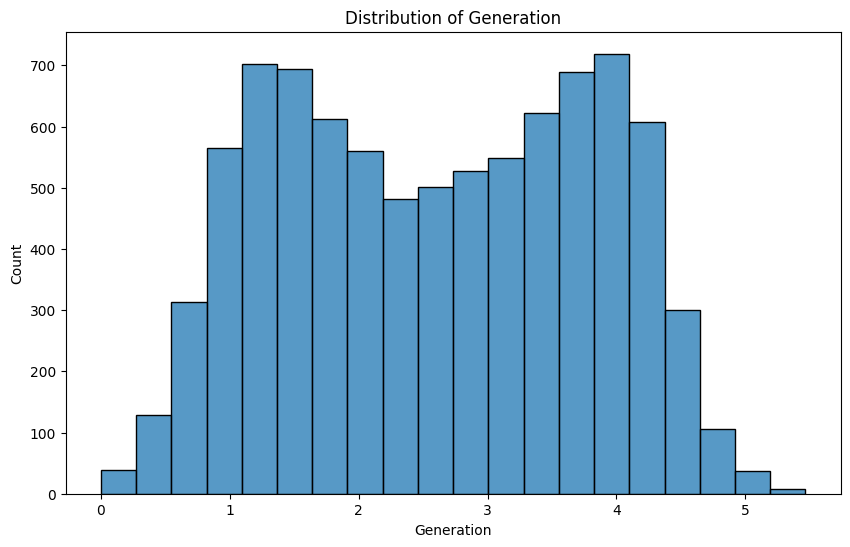

In [4]:
import seaborn as sns
for column in data.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], kde=False, bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.show()

In [5]:
from matplotlib.dates import DateFormatter

C:\Users\Florian\AppData\Local\Temp\ipykernel_6652\1643789987.py:13: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


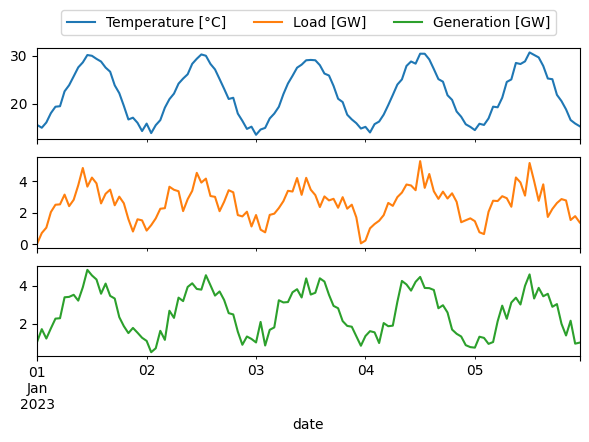

In [6]:
days_to_show = 5
df = data[:24*days_to_show].copy()
g = df.plot(subplots=True, figsize=(7, 4), legend=False)
handles, labels = [], []
unit = ['°C', 'GW', 'GW']
for i, ax in enumerate(g):
    for handle, label in zip(*ax.get_legend_handles_labels()):
        if label not in labels:
            handles.append(handle)
            labels.append(label + ' [{}]'.format(unit[i]))
plt.xlabel('date')
plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 3.9), ncol=len(labels))
plt.tight_layout()
plt.savefig('./plots/synthetic_features.pdf', bbox_inches='tight')
plt.show()

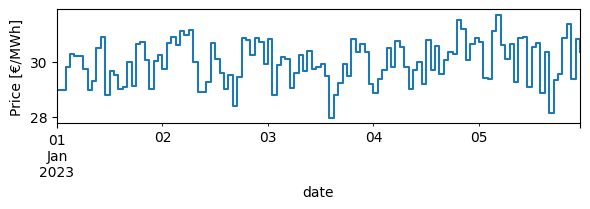

In [7]:
prediction_target[:24*days_to_show].plot(legend=False, figsize=(6, 2), drawstyle='steps-post', ylabel='Price [€/MWh]')
plt.tight_layout()
plt.xlabel('date')
plt.savefig('./plots/synthetic_price.pdf')
plt.show()

## model training

In [8]:
params = {
    "eta": 0.3,
    "max_depth": 6,
    'objective':'reg:squarederror'
}
model = xgb.train(params, 
                      xgb_train, 
                      num_boost_round=1000, 
                      evals = [(xgb_test, "test")], 
                      verbose_eval=1000,
                      early_stopping_rounds=100)

[0]	test-rmse:0.60499
[607]	test-rmse:0.04247


## model evaluation

In [9]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [10]:
y_pred = pd.DataFrame(index=y_test.index)
y_pred['xgb_pred'] = model.predict(xgb.DMatrix(X_test))
r2_score_xgb = r2_score(y_test, y_pred['xgb_pred'])
mae_xgb = mean_absolute_error(y_test, y_pred['xgb_pred'])
mse_xgb = mean_squared_error(y_test, y_pred['xgb_pred'])
print("R2: {:0.3f}".format(r2_score_xgb))
print("MAE: {:0.3f}".format(mae_xgb))
print("rmse: {:0.3f}".format(np.sqrt(mse_xgb)))
print("(mean label: {:0.3f})".format(y_test['Price'].mean()))

R2: 0.997
MAE: 0.024
rmse: 0.042
(mean label: 30.051)


# Shapley Flow

## Explanation settings

In [11]:
n_bg = 100 # number of sampled background samples
nsamples = 1000 # number of forefround samples to explain
nruns = 500
bg = X_test.sample(n=n_bg, random_state=0) 
fg = X_test.sample(n=nsamples, random_state=1)

## build causal graph

feature names: 
['Temperature', 'Load', 'Generation']
--------------------


learning dependency for Load:   0%|          | 0/1 [00:00<?, ?it/s]

[0]	test-rmse:1.02814
[100]	test-rmse:0.90846
[200]	test-rmse:0.81823
[300]	test-rmse:0.75132
[400]	test-rmse:0.70286
[499]	test-rmse:0.66864


learning dependency for Load: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]


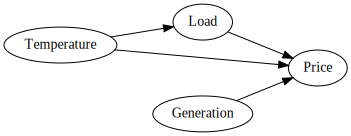

In [12]:
causal_links = CausalLinks()
target_name = 'Price'
feature_names = list(data.columns)
print('feature names: ')
print(feature_names)
print('--------------------')

# temp, load, generation, price <- my suggestion for synthetic model
# e.g. temp -> load; temp, load, generation -> price and ideally not temp -> price

causal_links.add_causes_effects(feature_names, 
                                target_name, 
                                create_xgboost_f(feature_names, model))
causal_links.add_causes_effects('Temperature', 'Load')


causal_graph = build_feature_graph(data.fillna(data.mean()), 
                                   causal_links=causal_links,
                                   target_name=target_name,
                                   method='xgboost')

causal_graph.draw(rankdir='LR')

## calculate Shapley Flow

In [13]:
num_processes = 8
from shap_flow_util import calculate_edge_credit
import time
import tqdm
import multiprocess as mp
import pickle

start = time.time()

model.set_param('n_jobs', -1)
model.set_param('device', 'cpu')

pool = mp.Pool(num_processes)
_args = [(causal_graph, bg[i:i+1], fg, nruns) for i in range(len(bg))]
edge_credits = pool.starmap(calculate_edge_credit, tqdm.tqdm(_args, total=len(_args)))
pool.close()
pool.join()

end = time.time()
print(end - start)

100%|██████████| 100/100 [24:15<00:00, 14.56s/it]


1544.7889182567596


In [14]:
model.set_param('n_jobs', -1)
explainer = GraphExplainer(causal_graph, bg[0:1], nruns, silent=False)
cf = explainer.shap_values(fg)

bruteforce sampling: 100%|██████████| 500/500 [00:21<00:00, 23.46it/s]


In [15]:
# save credit flow to file if necessary
import dill
cf.edge_credit = edge_credits2edge_credit(edge_credits, cf.graph)
if not os.path.exists('./credit_flow/'):
    os.makedirs('./credit_flow/')
with open('./credit_flow/{}.pkl'.format('test_synthetic_data'), 'wb') as file:
    dill.dump(cf, file)

## load cf

In [16]:
import dill

In [17]:
with open('./credit_flow/test_synthetic_data.pkl', 'rb') as file:
        cf = dill.load(file)

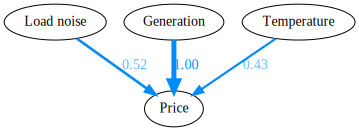

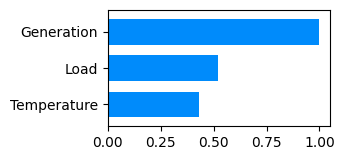

In [18]:
import importlib
import shap_flow_util

importlib.reload(shap_flow_util)
shap_flow_util.plot_bar_mean_abs_asv(cf, figsize=(3.5, 1.7), save=True, name='synthetic', xlabel='')

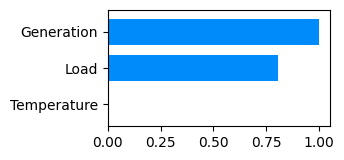

In [19]:
importlib.reload(shap_flow_util)
shap_flow_util.plot_bar_mean_abs_shap(cf, 'Price', figsize=(3.5, 1.7), save=True, name='synthetic', xlabel='')

## Shapley flow explanation

In [20]:
from shap_flow_util import save_graph_thesis

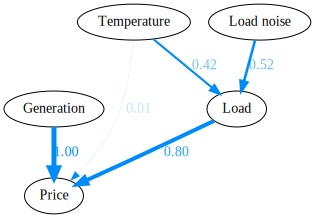

In [26]:
sample_ind = -1 # sample to inspect; set to negative value to get mean absolute credit (!)
cf.fold_noise = False
g = cf.draw(idx=sample_ind, show_fg_val=True)
#g.graph_attr['rankdir']='LR' # change layout from top-bottom to left-right
save_graph_thesis(g, './plots/sythetic_mean_abs', format='pdf', view=True)


# SHAP

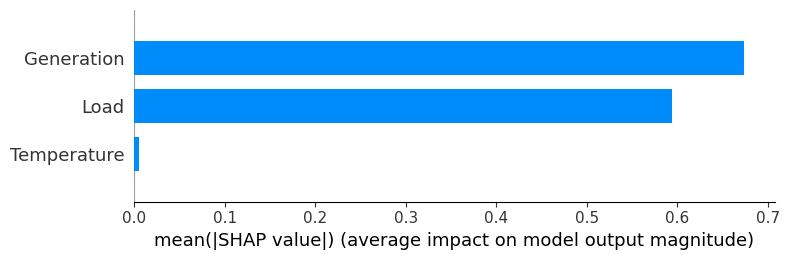

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(fg)
shap.summary_plot(shap_values, fg, plot_type='bar')

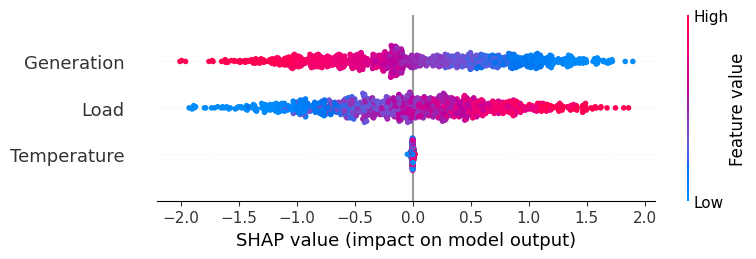

In [23]:
shap.summary_plot(shap_values, fg, plot_type='dot')

## SHAP interaction values

In [24]:
shap_interaction_values = explainer.shap_interaction_values(fg)

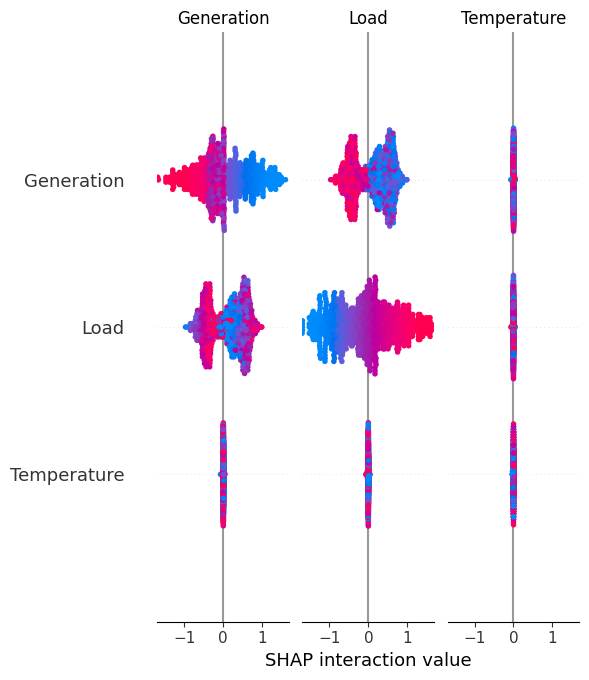

In [25]:
shap.summary_plot(shap_interaction_values, fg)
# interaction values uncover indirect effect of temperature